## A ML model to detect whether that's a Wes Anderson or a David Lynch movie


Starting off the Synagen blog with a fun one. This is really just a small toy example working through the [FastAI](https://www.fast.ai/) practical deep learning course, specifically [Lesson 1](https://course.fast.ai/Lessons/lesson1.html) and [Lesson 2](https://course.fast.ai/Lessons/lesson2.html) content.

In this post I show (interactively) how easy it is to train a simple object detection neural net in just a few lines of python code.

Deep Learning has made some serious advances in recent years when it comes to image and video data, so it shouldn't surprise anyone how well architectures like Convolutional Neural Networks (CNNs) can easily identify humans/animals/objects in photos.

So instead of doing yet *another* dog/cat classifier, I set out to challenge the AI a bit: could it detect who directed a movie based only on a screenshot, and only after being trained on **other** movies from the same director?

That last bit is quite important - I assume it would be no challenge to detect scenes from the same movie that the model was trained on, but will the learnings about a director's artistic style translate even to new movies that the model has never seen before?

To find out, I picked two of my favourite directors - Wes Anderson and David Lynch - , then downloaded a bunch of images of scenes from some of their most iconic works, and trained a deep learning model to classify each scene.

Read on to find out how it went...

### Libraries

In [1]:
from fastbook import *
from fastai.vision import *
from fastai.vision.widgets import *
from decouple import config, AutoConfig

### Gather Data


Here we use Bing to search for images. I found that adding the director's name and 'scene' at the end of the search query yielded best results. Below is a sample image from Anderson's earliest film: Bottle Rocket

In [2]:
config = AutoConfig(' ')
key = config('AZURE_SEARCH_KEY')

In [3]:
results = search_images_bing(key, 'wes anderson bottle rocket scene')
ims = results.attrgot('contentUrl')
len(ims)

150

In [4]:
dest = 'bottlerocket.jpg'
download_url(ims[0], dest)

Path('bottlerocket.jpg')

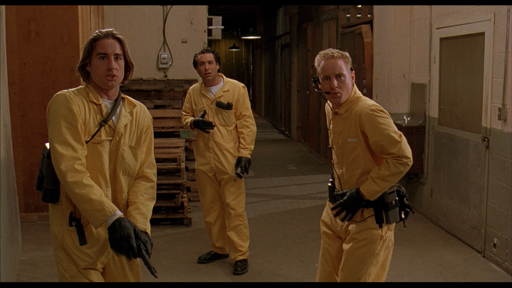

In [5]:
im = Image.open(dest)
im.to_thumb(512,512)

Let's get the rest of the movie scenes downloaded!

Here I separate our data into training and validation sets. Specifically, I picked The French Dispatch and Moonrise Kingdom as Wes Anderson validation movies, and similarly singled out Mulholland Drive and Blue Velvet from Lynch's colletion.

I did find that if we downloaded too many images from each movie, they would start getting repetitive/not relevant (e.g. pictures of movie posters rather than actual scenes from the movies), so I limit the search to the first 30 results from each.

In [6]:
wa_movies_train = ['bottle rocket','rushmore','the royal tenebaums', 'the life aquatic with steve zissou',
            'the darjeeling limited','the grand budapest hotel','asteroid city']
wa_movies_val = ['the french dispatch','moonrise kingdom',]

dl_movies_train = ['eraserhead','the elephant man','wild at heart',
            'twin peaks','lost highway','inland empire']
dl_movies_val = ['mulholland drive','blue velvet',]

path = Path('movies')

In [7]:
if not path.exists():
    path.mkdir()
train_path = (path/'training')
if not train_path.exists():
    train_path.mkdir()
    for o in wa_movies_train:
        dest = (train_path/'wesanderson')
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'wes anderson {o} scene', max_images=30)
        download_images(dest, urls=results.attrgot('contentUrl'))
    for o in dl_movies_train:
        dest = (train_path/'davidlynch')
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'david lynch {o} scene', max_images=30)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
val_path = (path/'validation')
if not val_path.exists():
    val_path.mkdir()
    for o in wa_movies_val:
        dest = (val_path/'wesanderson')
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'wes anderson {o} scene', max_images=30)
        download_images(dest, urls=results.attrgot('contentUrl'))
    for o in dl_movies_val:
        dest = (val_path/'davidlynch')
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'david lynch {o} scene', max_images=30)
        download_images(dest, urls=results.attrgot('contentUrl'))

Here we remove any broken links:

In [9]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

### Preparing Dataloaders


Now that we have all our data collected, let's prepare it for our ML model using fastai's `DataBlock` class:

To break it down, we specify the following:
 - The type of blocks (input = images, output = categories)
 - How to get our data? Using the `get_image_files` function
 - How to split training/validation? Based on the folder names 2 levels up
 - How to label our data? Based on the folder names 1 level up
 - How to transform our data? Resize all images to a standard 256x256 pixels

In [10]:
scenes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='training', valid_name='validation'),
    get_y=parent_label,
    item_tfms=Resize(256))

Now that we have everything specified, let's load in our data (making sure to suffle both train and val sets) and display a batch of images:

In [11]:
dl_train = scenes.dataloaders(path, shuffle=True, val_shuffle=True)

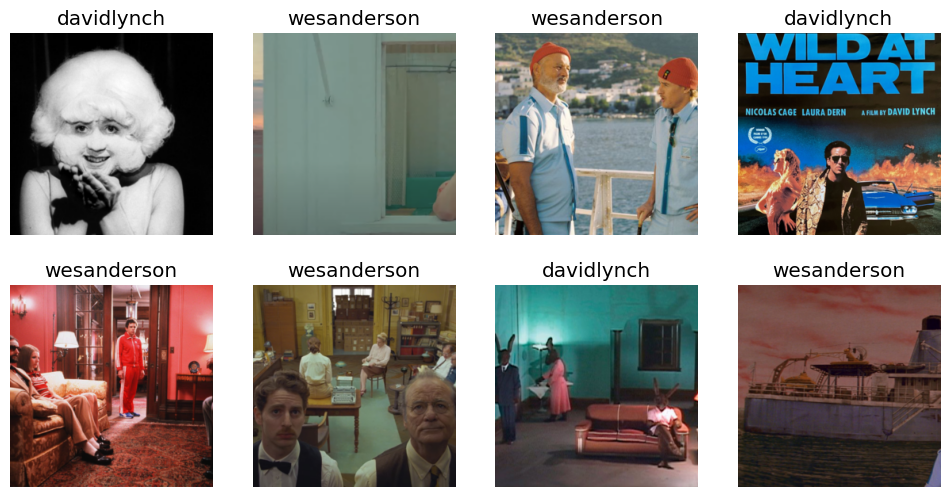

In [12]:
dl_train.train.show_batch(max_n=8, nrows=2)

Looking good...

There may be some images in here that we want to remove (e.g. ones with movie titles, or multiple scenes in one image), but we will deal with that later.

First, let's actually train our model and see how it does!

In [13]:
learn = vision_learner(dl_train, resnet18, metrics=accuracy)
learn.fine_tune(6)

/Users/richardrossmann/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/richardrossmann/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Something interesting here is that even though we trained for 6 epochs, the valiation loss actually stopped improving after only 3. We could have stopped training there - the training loss still improves but this is likely just overfitting on our input data.

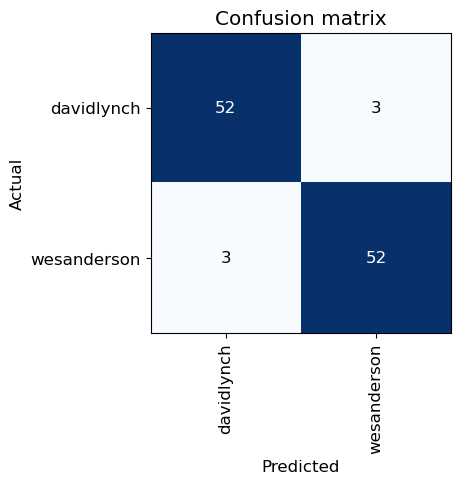

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

So that took about a minute to train\*, and we now have a machine learning model that can tell the difference between Wes Anderson and David Lynch in over 95% of our examples.

\*we did use a pretrained model so that saved a LOT of time!

Let's now go through our dataset and remove any shots of filming, duplicates, or other images that are just adding noise.


In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [19]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now let's run our data prep -> model training -> accuracy scoring steps again:

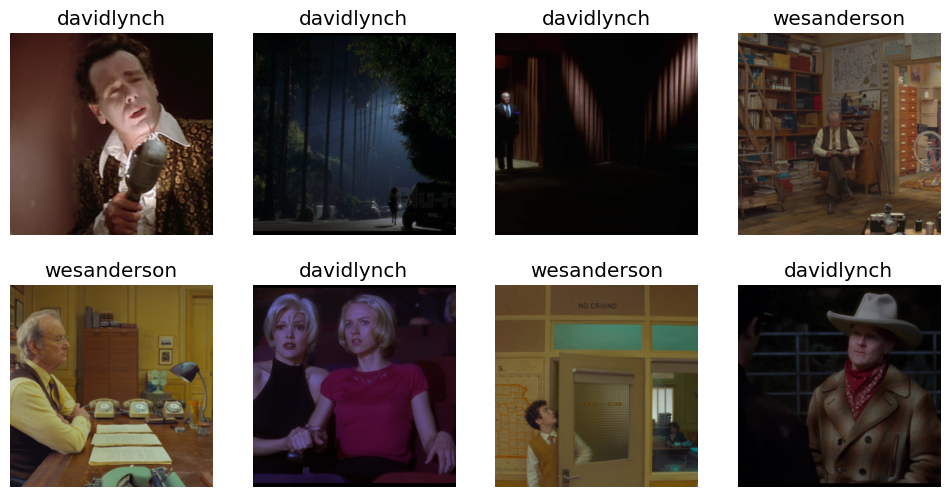

In [20]:
dl_train = scenes.dataloaders(path, shuffle=True, val_shuffle=True)
dl_train.valid.show_batch(max_n=8, nrows=2)

In [24]:
learn = vision_learner(dl_train, resnet18, metrics=accuracy)
learn.fine_tune(3)

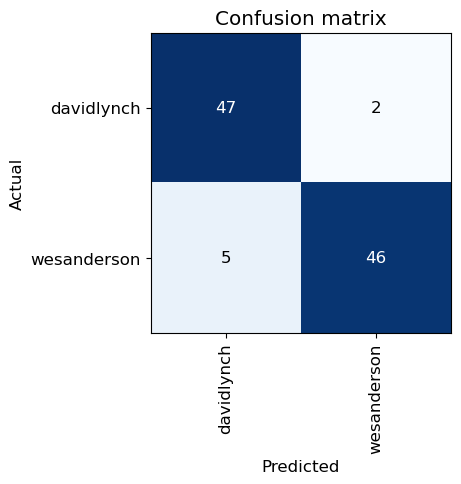

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

And what do the results actually look like? Below we take a look at some validation set images, with the actual and predicted labels printed above the pictures. Not bad!

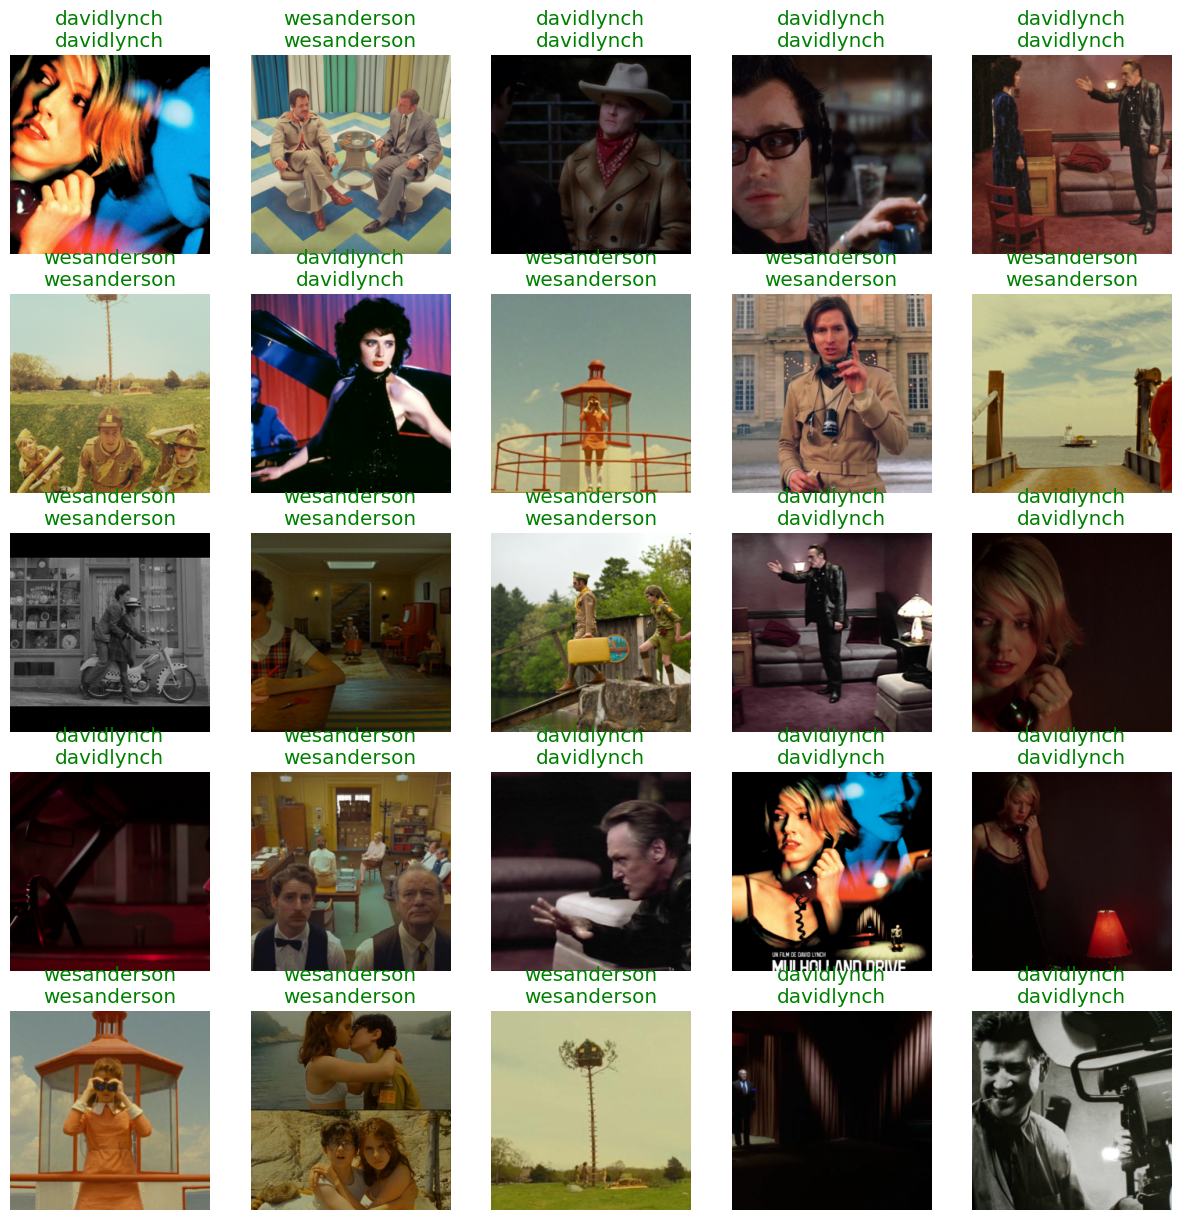

In [32]:
interp.show_results(list(range(0,100,4)))

We can also take a look at which images the model struggles with by using `plot_top_losses`. I'd say that even diehard fans might struggle with a couple of these!

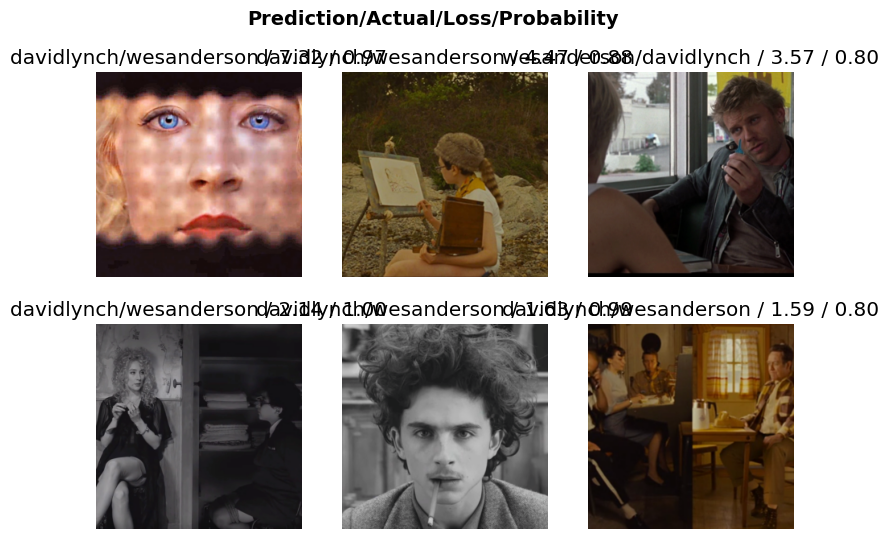

In [36]:
interp.plot_top_losses(6, nrows=2)

The first shot of Saoirse Ronan from The French Dispatch looks a lot like Naomi Watts in Mulholland Drive, while the middle lower image of Timothée Chalamet could have been taken straight out of Lynch's Eraserhead!

(-0.5, 1279.5, 799.5, -0.5)

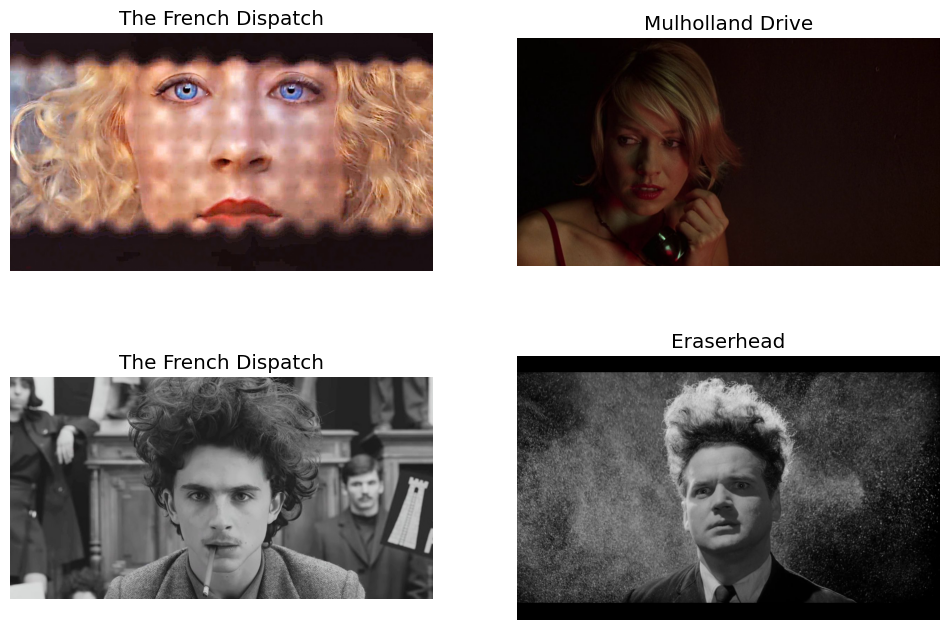

In [60]:
#hide
f, axarr = plt.subplots(2,2)
f.set_figheight(8)
f.set_figwidth(12)
axarr[0,0].imshow(Image.open(Path('movies')/'validation/wesanderson/20fa22db-b9d3-4eae-9537-d4c2c68095c4.jpg'))
axarr[0,0].set_title("The French Dispatch")
axarr[0,0].axis('off')
axarr[0,1].imshow(Image.open(Path('movies')/'validation/davidlynch/b8f11185-392e-4be4-a2d6-99b00cb04783.jpg'))
axarr[0,1].set_title("Mulholland Drive")
axarr[0,1].axis('off')
axarr[1,0].imshow(Image.open(Path('movies')/'validation/wesanderson/3e787a80-3f2e-4dc5-a27d-82ea56733a15.jpg'))
axarr[1,0].set_title("The French Dispatch")
axarr[1,0].axis('off')
axarr[1,1].imshow(Image.open(Path('movies')/'training/davidlynch/2e17a81a-c911-4f23-afe5-5c89bdc07bdf.png'))
axarr[1,1].set_title("Eraserhead")
axarr[1,1].axis('off')

Coincidence? Or perhaps some artistic influence from Lynch's earlier works infiltrated Anderson's mind when producing The French Dispatch? Well if even our state-of-the-art ML model cannot tell them apart, perhaps there is some evidence of inspiration, but I guess we'll never know for sure...